# Preliminary exploration of GSE77110

Tong Shu Li

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
sys.path.append('../..')

In [3]:
from src.plots import plot_multi_density
from src.plots import plot_drift
from src.plots import plot_p_val_heatmap
from src.plots import pointplot

In [4]:
%matplotlib inline

---

## Read the GSE77110 data

In [5]:
data = pd.read_csv("../../data/PMID26959186/GSE77110/annot_GSE77110.tsv", sep = '\t')

In [6]:
data.shape

(339375, 13)

In [7]:
data.head()

,probe_id,geo_id,log2_exp,sample,diet,days_old,entrez_id,wormbase_id,ensembl_id,other_id,ref_log2_exp,exp_percentile,lfe
0,171720_x_at,GSM2044469,8.717144,N2_AL_AD2,AL,2,174997,NaN,WBGene00013011,AV179929,8.717144,70.514917,0.0
1,171721_x_at,GSM2044469,11.016367,N2_AL_AD2,AL,2,172609,NaN,WBGene00011344,6767,11.016367,91.973481,0.0
2,171722_x_at,GSM2044469,11.863110,N2_AL_AD2,AL,2,176907,NaN,WBGene00018934,AV189310,11.863110,96.296133,0.0
3,171723_x_at,GSM2044469,14.501900,N2_AL_AD2,AL,2,180646,CE26817,WBGene00006928,CEC7564,14.501900,99.986740,0.0
4,171724_x_at,GSM2044469,10.306531,N2_AL_AD2,AL,2,172353,CE11778,WBGene00000386,AV178012,10.306531,86.205525,0.0


---

## Gene expression distribution for all samples

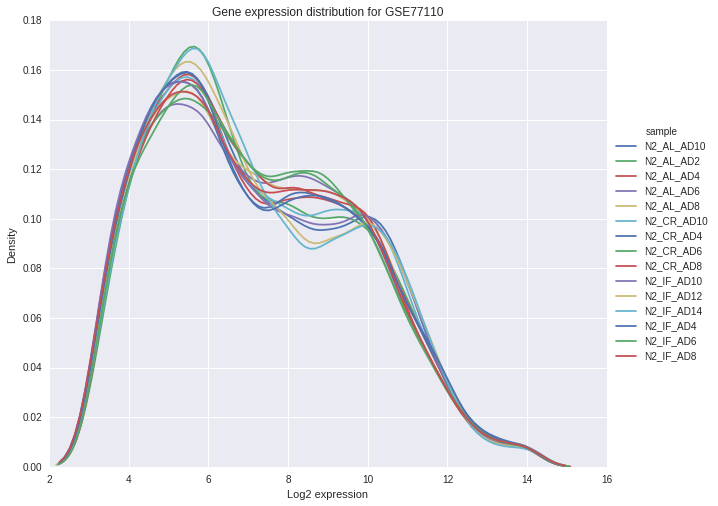

In [8]:
ax = plot_multi_density(
    data, "sample", "log2_exp",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Gene expression distribution for GSE77110")
ax.set_xlabel("Log2 expression");

The expression distributions look quite good, but not quite log normal. While the means and variances are all very close, it seems like the expression is composed of two Gaussian distributions of different means.

## Log fold expression distribution

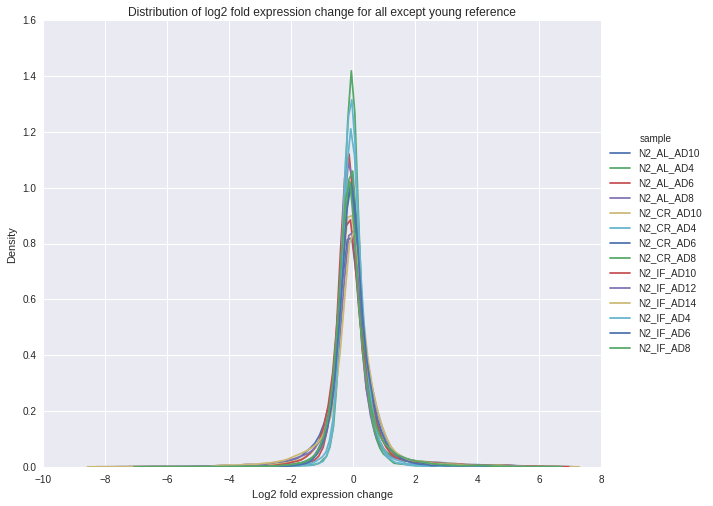

In [9]:
ax = plot_multi_density(
    data.query("sample != 'N2_AL_AD2'"),
    "sample", "lfe",
    rc = {"figure.figsize": (10, 8)}
)

ax.set_title("Distribution of log2 fold expression change for all except young reference")
ax.set_xlabel("Log2 fold expression change");

The log expression change has a mean of zero by default. These data seem very promising, but we will probably need to control for the tails with the large LFE values.

## LFE as a function of original expression

In [10]:
data["decile"] = data["exp_percentile"].map(
    lambda v: math.floor(v) // 10
)

### Control diet worms

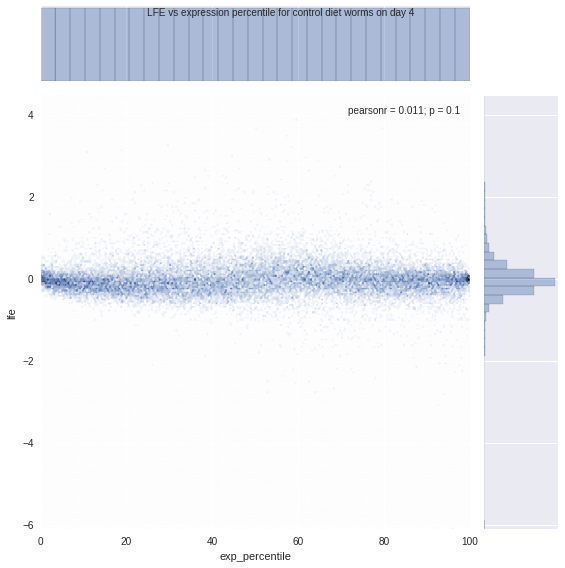

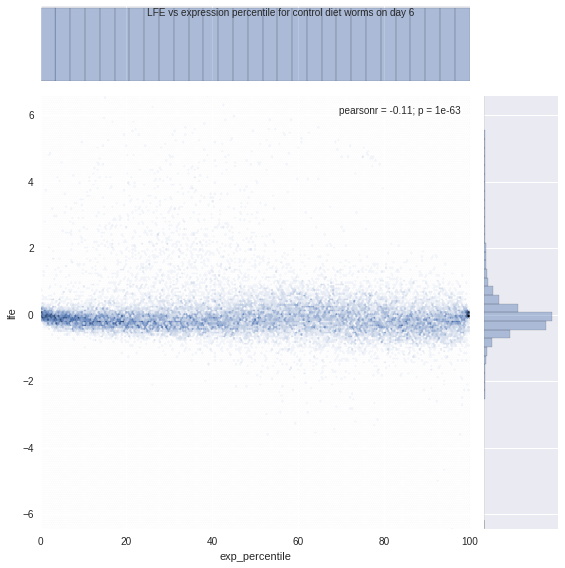

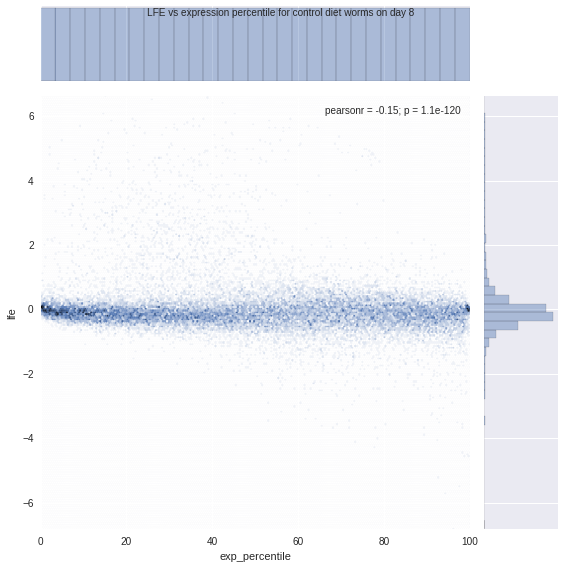

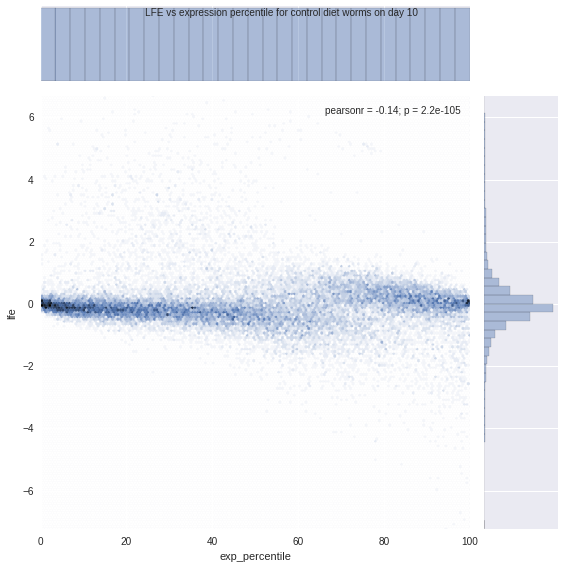

In [11]:
for key, df in data.query("diet == 'AL' & days_old > 2").groupby("days_old"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "lfe",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("LFE vs expression percentile for control diet worms on day {}".format(key))

Everything looks great for these data until you reach the last day (day 10). I wonder why there is an obvious shift in the mean LFE change at around the 70th percentile of expression?

### Caloric restricted worms

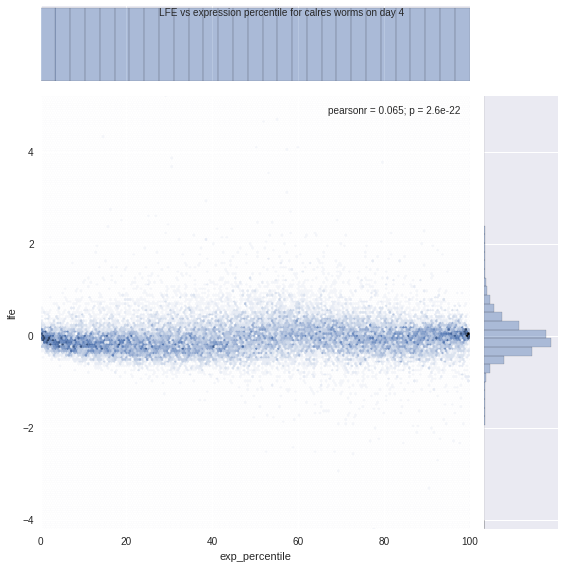

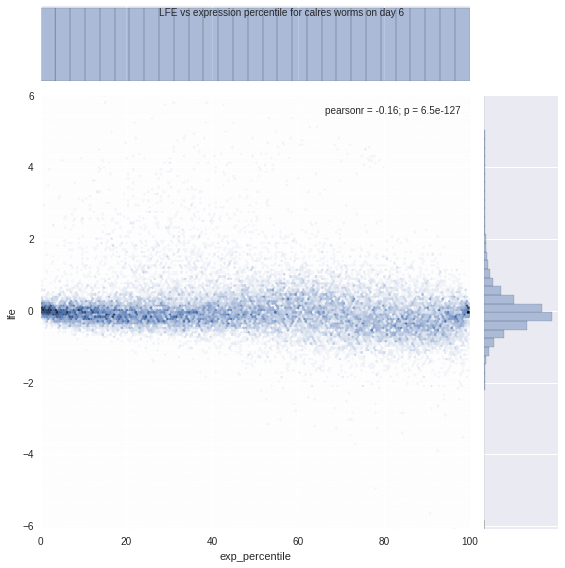

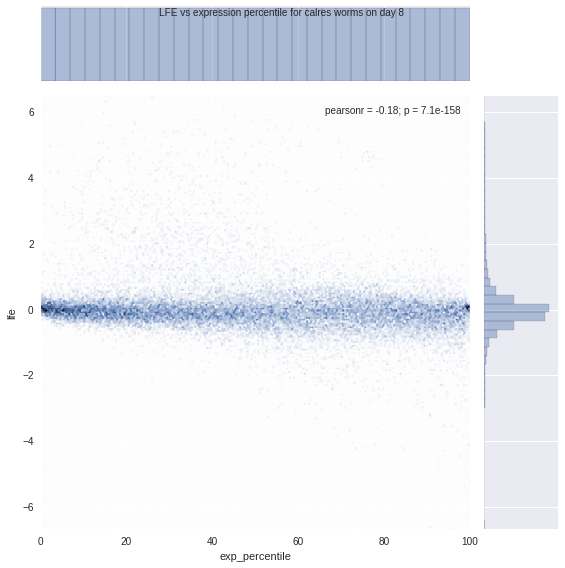

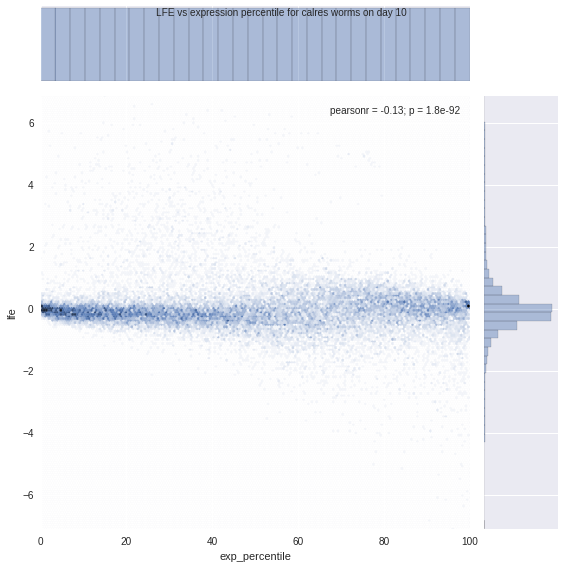

In [12]:
for key, df in data.query("diet == 'CR'").groupby("days_old"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "lfe",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("LFE vs expression percentile for calres worms on day {}".format(key))

### Intermittent fasting worms

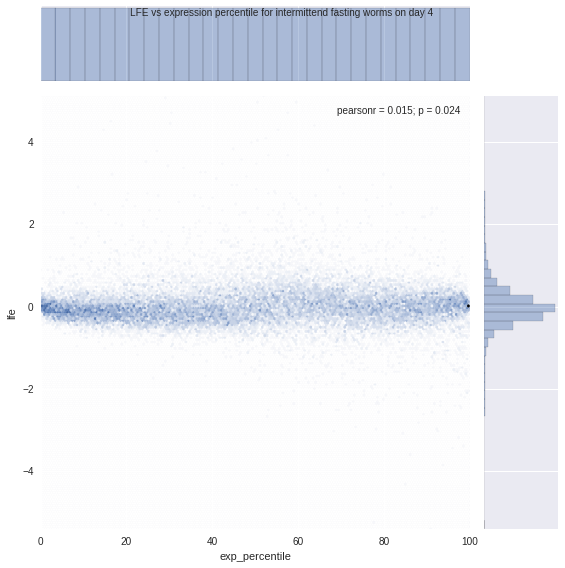

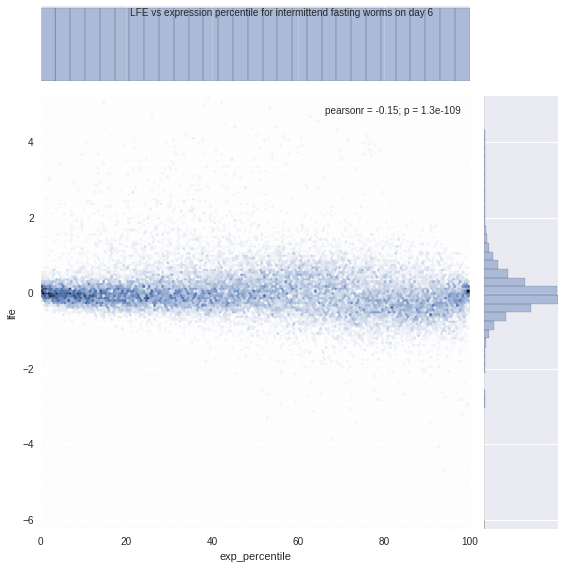

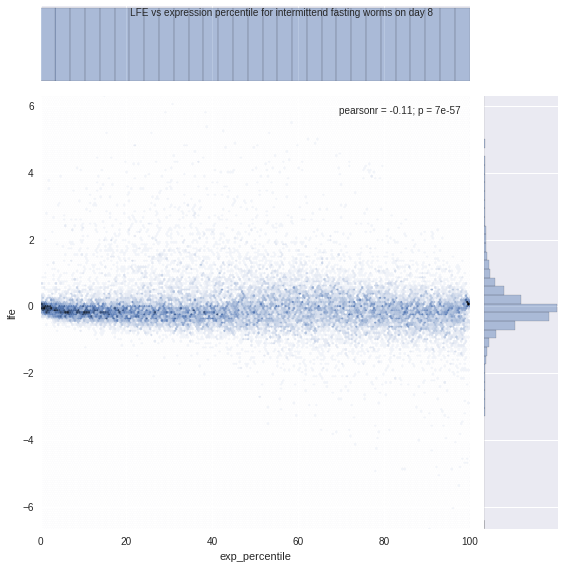

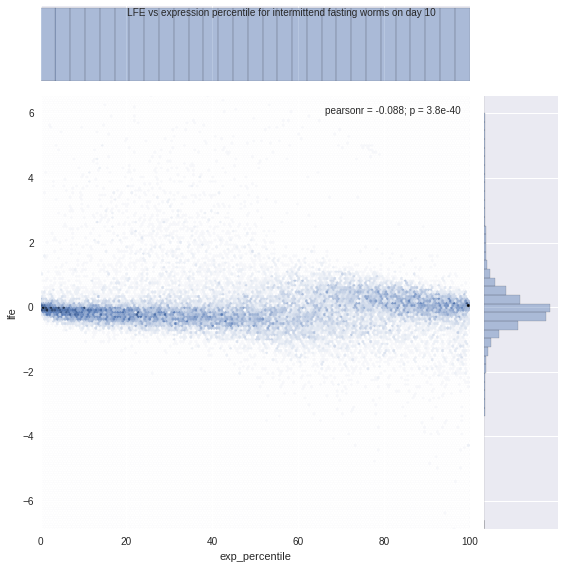

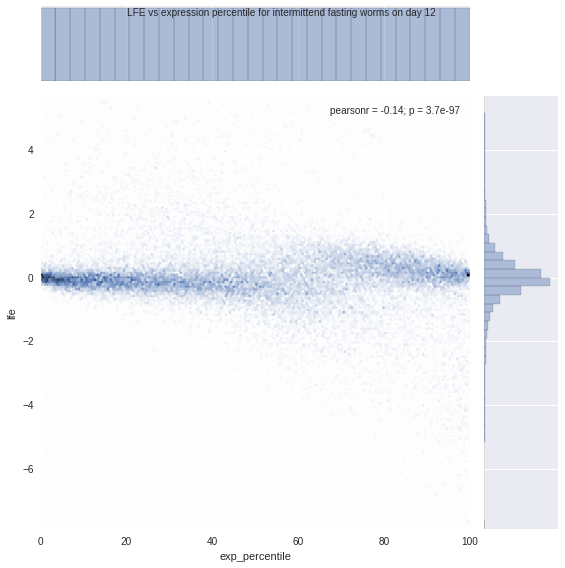

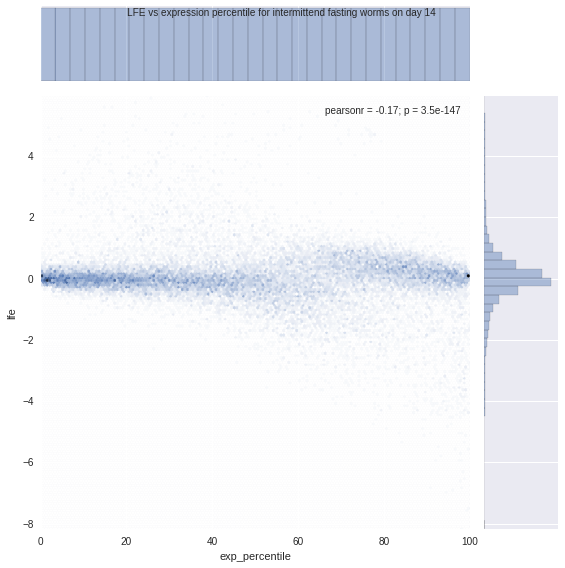

In [13]:
for key, df in data.query("diet == 'IF'").groupby("days_old"):
    ax = sns.jointplot(
        data = df,
        x = "exp_percentile",
        y = "lfe",
        kind = "hex",
        size = 8
    )
    
    ax.fig.suptitle("LFE vs expression percentile for intermittend fasting worms on day {}".format(key))

I wonder why we don't see the same skew towards an increase in LFE in the lower expressed genes like we did with the mianserin dataset. Although there are still large numbers of genes which have high LFEs, there is a much clearer trend of a mean of zero across all gene expression levels. Maybe this is caused by the microarray technique?

## Drift variance as a function of original expression

### Control diet worms

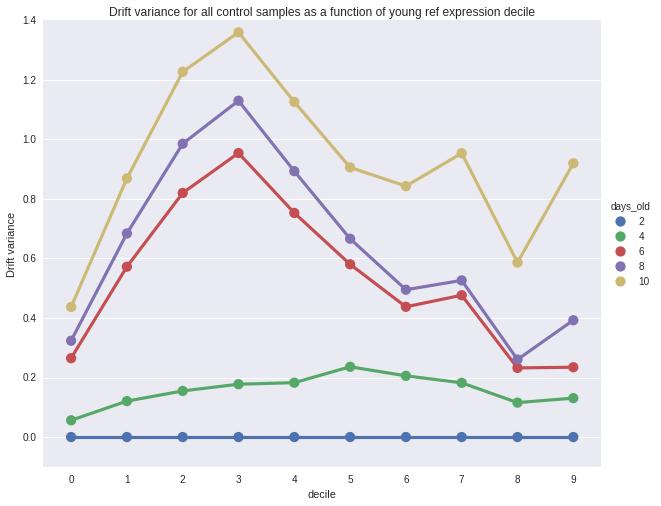

In [14]:
ax = (data.query("diet == 'AL'")
    .groupby(["days_old", "decile"], as_index = False)
    .agg({"lfe": np.var})
    .rename(columns = {"lfe": "lfe_var"})
    .pipe(
        pointplot, "decile", "lfe_var", "days_old",
        rc = {"figure.figsize": (10, 8)}
    )
)

ax.set_title("Drift variance for all control samples as a function of young ref expression decile")
ax.legend(title = "days_old", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylim((-0.1, 1.4))
ax.set_ylabel("Drift variance");

The drift variance increases as the age of the worm increases. This increase does not seem to be linear though (note how day 4 looks very different from day 6). Also it is strange seeing such a large bump in the 3rd decile (we did not observe this with the mianserin data). Overall the pattern looks very different than the mianserin dataset, but the general rule of variance increasing with time still holds.

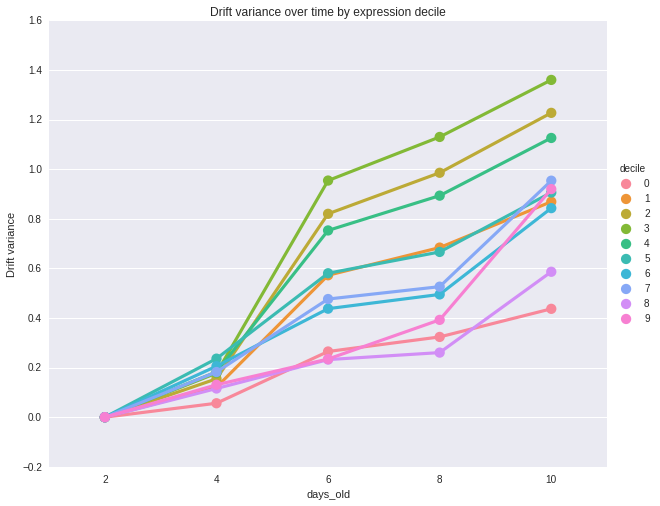

In [15]:
ax = (data.query("diet == 'AL'")
    .groupby(["days_old", "decile"], as_index = False)
    .agg({"lfe": np.var})
    .rename(columns = {"lfe": "lfe_var"})
    .pipe(
        pointplot, "days_old", "lfe_var", "decile",
        rc = {"figure.figsize": (10, 8)}
    )
)

ax.set_title("Drift variance over time by expression decile")
ax.legend(title = "decile", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

### Control worms and caloric restriction worms

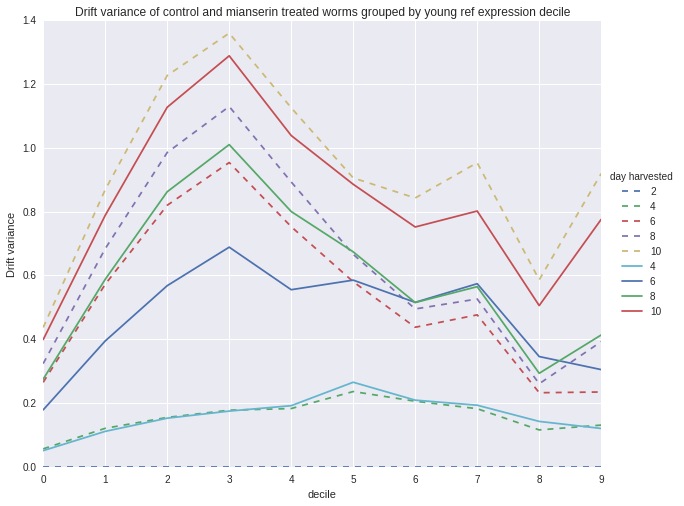

In [16]:
res = pd.DataFrame(
    [
        (day, decile, df["lfe"].var())
        for (day, decile), df in (data.query("diet == 'AL'")
                                  .groupby(["days_old", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = "--", figsize = (10, 8))


res = pd.DataFrame(
    [
        (day, decile, df["lfe"].var())
        for (day, decile), df in (data.query("diet == 'CR'")
                                  .groupby(["days_old", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = '-', ax = ax, figsize = (10, 8))

ax.set_title("Drift variance of control and mianserin treated worms grouped by young ref expression decile")

ax.legend(title = "day harvested", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

The regular diet worms are dotted lines above, and the caloric restricted worms solid lines. It seems that the caloric restriction makes no difference at day 4, but starts reducing drift later on. Here we see a different pattern than in the mianserin dataset. Instead of the drug treated worms all being smaller than a certain control date, each treatment age is only slightly smaller than the untreated at the same time.

### Control and Intermittent fasting

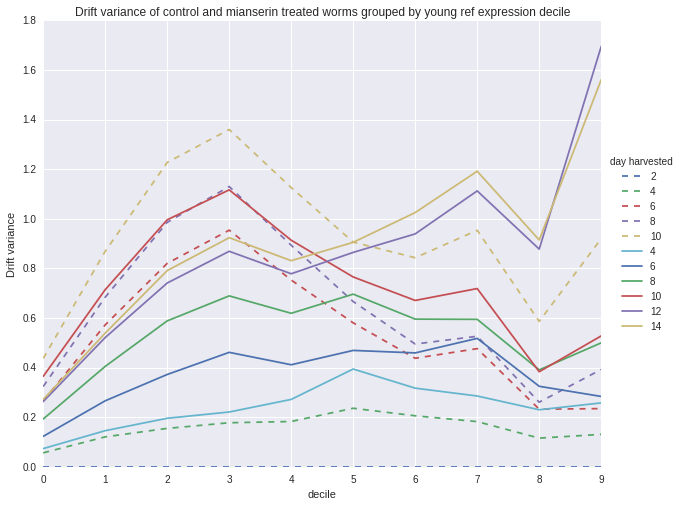

In [17]:
res = pd.DataFrame(
    [
        (day, decile, df["lfe"].var())
        for (day, decile), df in (data.query("diet == 'AL'")
                                  .groupby(["days_old", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = "--", figsize = (10, 8))


res = pd.DataFrame(
    [
        (day, decile, df["lfe"].var())
        for (day, decile), df in (data.query("diet == 'IF'")
                                  .groupby(["days_old", "decile"]))
    ],
    columns = ["day", "decile", "drift_var"]
).pivot("decile", "day", "drift_var")

ax = res.plot(kind = "line", linestyle = '-', ax = ax, figsize = (10, 8))

ax.set_title("Drift variance of control and mianserin treated worms grouped by young ref expression decile")

ax.legend(title = "day harvested", loc = "center left", bbox_to_anchor = (1, 0.5))
ax.set_ylabel("Drift variance");

No pattern in the drift variance jumps out to me in the intermittent fasting data. Overall the intermittent fasting groups may be a bit younger based on the variance of the 3rd decile, but the last few deciles looks quite strange.

## Conclusion

Based on these data, it does not seem like there is some filtering rule which we should apply to the dataset. We will therefore include all genes for the GO term analysis.

## Drift plots

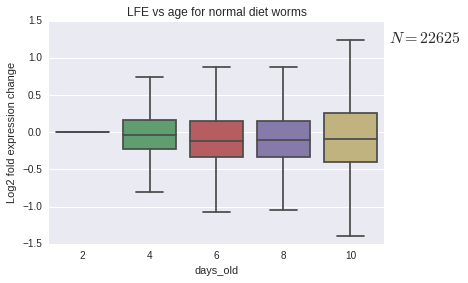

In [18]:
ax = plot_drift(
    "box", data.query("diet == 'AL'"),
    "days_old", "lfe", "probe_id",
    title = "LFE vs age for normal diet worms"
)

ax.set_ylabel("Log2 fold expression change");

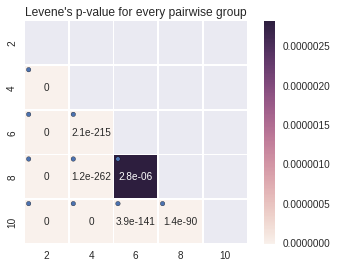

In [19]:
plot_p_val_heatmap(data.query("diet == 'AL'"), "days_old", "lfe", circles = True);

Not terribly impressed with the drift results of this whole dataset. I wonder why we see no increase from day 6 to 8, whereas there is an increase from day 4 to 6, and from day 8 to 10. Levene's test here again is useless, since we would expect any group of 20k genes to detect a difference.

### Control vs caloric restriction

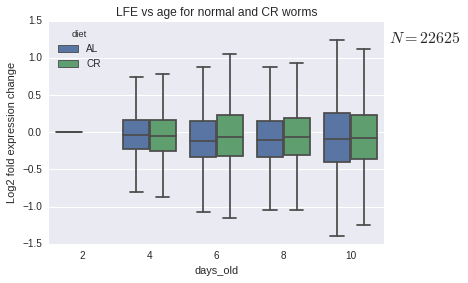

In [20]:
ax = plot_drift(
    "box", data.query("diet in('AL', 'CR')"),
    "days_old", "lfe", "probe_id",
    title = "LFE vs age for normal and CR worms",
    groupby = "diet"
)

ax.set_ylabel("Log2 fold expression change");

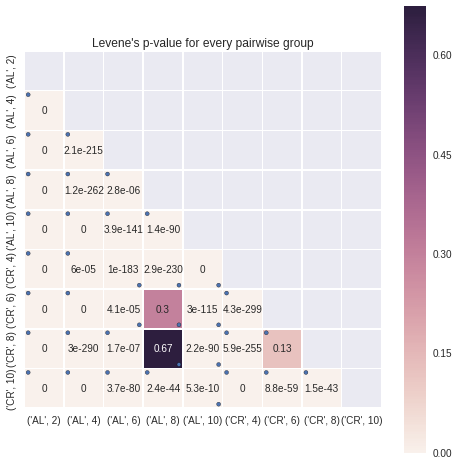

In [21]:
plot_p_val_heatmap(
    data.query("diet in('AL', 'CR')"), ["diet", "days_old"], "lfe", circles = True,
    rc = {"figure.figsize": (8, 8)}
);

There doesn't seem to be a consistent pattern in the control vs caloric restriction worms. If anything, it looks like the CR worms are actually older for the first 8 days, and then there is a slight reduction on day 10.

### Control vs intermittent fasting

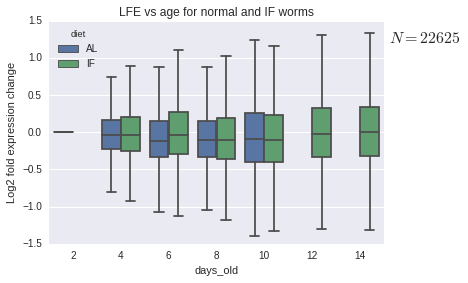

In [22]:
ax = plot_drift(
    "box", data.query("diet in('AL', 'IF')"),
    "days_old", "lfe", "probe_id",
    title = "LFE vs age for normal and IF worms",
    groupby = "diet"
)

ax.set_ylabel("Log2 fold expression change");

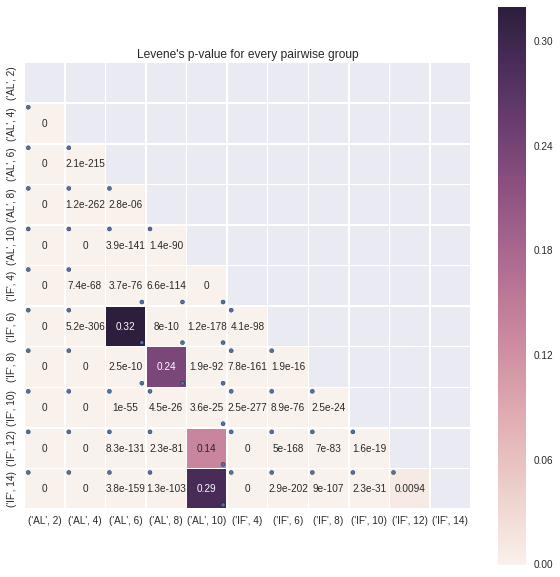

In [23]:
plot_p_val_heatmap(
    data.query("diet in('AL', 'IF')"), ["diet", "days_old"], "lfe", circles = True,
    rc = {"figure.figsize": (10, 10)}
);

Same thing with the intermittent fasting worms. If anything, the IF worms look older than the control worms.

## All groups together

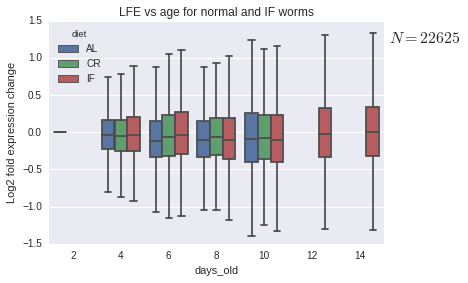

In [24]:
ax = plot_drift(
    "box", data,
    "days_old", "lfe", "probe_id",
    title = "LFE vs age for normal and IF worms",
    groupby = "diet"
)

ax.set_ylabel("Log2 fold expression change");

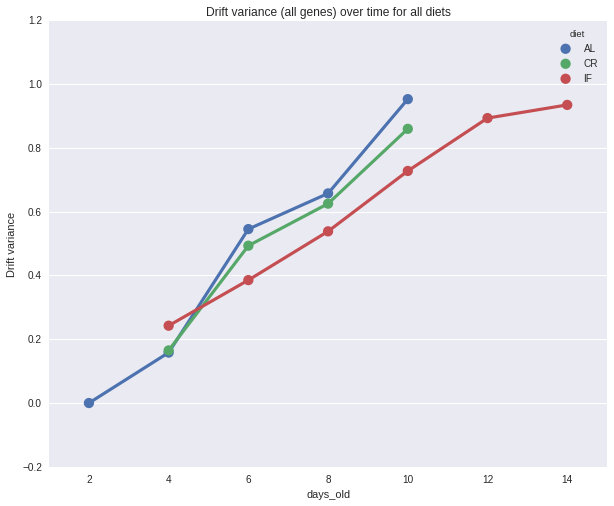

In [25]:
ax = (data.groupby(["diet", "days_old"], as_index = False)
    .agg({"lfe": np.var})
    .rename(columns = {"lfe": "lfe_var"})
    .pipe(
        pointplot, "days_old", "lfe_var", "diet",
        rc = {"figure.figsize": (10, 8)}
    )
)

ax.set_ylabel("Drift variance")
ax.set_title("Drift variance (all genes) over time for all diets");

Maybe this is support for Michael's hypothesis that the transcriptomes of CR worms are actually old, but that the worms live longer because they don't have enough amino acids to make the bad proteins?